In [1]:
import logging
import os
import time

import numpy as np
import scipy.io as sci
from matplotlib import image
from matplotlib import pyplot as plt

import library as lib
from model import dsfa

E:\Program\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# parameters
max_epochs = 3000
lr = 1e-4
lamb = 1e-4
ratio = 2 * 1e-2
# for DAE module
Use_DAE = False
noise_scale = 1e-1
# 
train_num = 4000
patch_size = 1
max_iter = 10
net_shape = [128, 128, 9]
area = 'taizhou'

In [3]:
# settings
if os.path.exists(area+'/dsfa') is False:
    os.mkdir(area+'/dsfa')

logging.basicConfig(format='%(asctime)-15s %(levelname)s: %(message)s',datefmt='%m/%d/%Y %H:%M:%S',level=logging.INFO)

In [4]:

def load_data(area='taizhou'):

    img1_path = area + '/1.mat'
    img2_path = area + '/2.mat'
    change_path = area + '/change.bmp'
    un_path = area + '/unchange.bmp'

    mat1 = sci.loadmat(img1_path)
    mat2 = sci.loadmat(img2_path)

    img1 = mat1['im']
    img2 = mat2['im']

    chg_map = image.imread(change_path)
    un_map = image.imread(un_path)

    return img1, img2, chg_map, un_map


def get_img(fcx, fcy, vp):

    delta = np.matmul(fcx, vp) - np.matmul(fcy, vp)

    delta = delta / np.std(delta, axis=0)

    differ_map = delta

    delta = delta**2

    dd = np.sum(delta, axis=1)

    vv = dd / np.max(dd)

    im = np.reshape(lib.kmeans(vv), img_shape[0:-1], order='f')
    return im, dd, differ_map

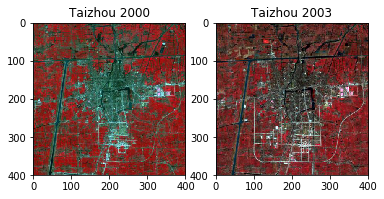

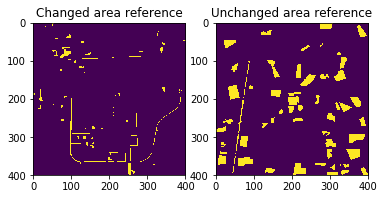

In [5]:
img1, img2, chg_map, un_map = load_data(area=area)

plt.figure()
plt.subplot(121)
a1=plt.imread(area+'/taizhou2000.jpg')
plt.imshow(a1)
plt.title('Taizhou 2000')
plt.subplot(122)
a2=plt.imread(area+'/taizhou2003.jpg')
plt.imshow(a2)
plt.title('Taizhou 2003')

plt.figure()
plt.subplot(121)
plt.imshow(chg_map)
plt.title('Changed area reference')
plt.subplot(122)
plt.imshow(un_map)
plt.title('Unchanged area reference')
plt.show()



In [6]:
im1 = lib.gen_patch(im=img1, patch_size=patch_size)
im2 = lib.gen_patch(im=img2, patch_size=patch_size)

im1 = lib.normlize(im1)
im2 = lib.normlize(im2)

img_shape = np.shape(img1)

chg = np.reshape(chg_map, newshape=[-1])
un = np.reshape(un_map, newshape=[-1])

In [7]:
ind = sci.loadmat(area+'/ind.mat')
cva_ind = ind['cva_ind']
cva_ind = np.reshape(cva_ind, newshape=[-1])
sfa_ind = ind['sfa_ind']
sfa_ind = np.reshape(sfa_ind, newshape=[-1])
isfa_ind = ind['isfa_ind']
isfa_ind = np.reshape(isfa_ind, newshape=[-1])

In [8]:
imm = None
ddd = None
differ = np.zeros(shape=[np.shape(chg)[0],net_shape[-1],max_iter])

In [9]:
for k1 in range(max_iter):

    logging.info('The %2d-th iteration········' % (k1))

    i1, i2 = lib.pick(cva_ind, im1, im2, train_num)

    if Use_DAE:
        i1 = lib.add_noise(i1, noise_scale)
        i2 = lib.add_noise(i2, noise_scale)

    loss_log, vpro, fcx, fcy, bval = dsfa(xtrain=i1, ytrain=i2, xtest=im1, ytest=im2, net_shape=net_shape, Use_DAE=Use_DAE, max_epochs=max_epochs, lr=lr, lamb=lamb, ratio=ratio)
    im, dd, dm = get_img(fcx, fcy, vpro)
    dd = np.reshape(dd, img_shape[0:-1], order='f')
    differ[:,:,k1]=dm
    if ddd is None:
        ddd = dd / np.max(dd)

    else:
        ddd = ddd + dd / np.max(dd)
aa = np.reshape(lib.kmeans(np.reshape(ddd, [-1])), img_shape[0:-1])
    
# plt.imsave('change_intensity.jpg', ddd, cmap='gray')
# plt.imsave('change_binary.jpg', aa, cmap='gray')
# plt.imsave('chg_intensity.jpg', imm, cmap='gray')
# plt.imsave('chg_binary.jpg', avg, cmap='gray')
logging.info('Max value of change intensity: %.4f'%(np.max(ddd)))
logging.info('Max value of change intensity: %.4f'%(np.min(ddd)))

11/16/2018 16:03:29 INFO: The  0-th iteration········
11/16/2018 16:03:31 INFO: The    0-th epochs, loss is 1.9259 
11/16/2018 16:03:31 INFO: The  100-th epochs, loss is 1.4214 
11/16/2018 16:03:32 INFO: The  200-th epochs, loss is 1.4344 
11/16/2018 16:03:32 INFO: The  300-th epochs, loss is 1.2745 
11/16/2018 16:03:32 INFO: The  400-th epochs, loss is 1.3927 
11/16/2018 16:03:33 INFO: The  500-th epochs, loss is 1.3466 
11/16/2018 16:03:33 INFO: The  600-th epochs, loss is 1.1315 
11/16/2018 16:03:34 INFO: The  700-th epochs, loss is 1.1705 
11/16/2018 16:03:34 INFO: The  800-th epochs, loss is 1.3259 
11/16/2018 16:03:34 INFO: The  900-th epochs, loss is 1.2937 
11/16/2018 16:03:35 INFO: The 1000-th epochs, loss is 1.1374 
11/16/2018 16:03:35 INFO: The 1100-th epochs, loss is 1.1521 
11/16/2018 16:03:36 INFO: The 1200-th epochs, loss is 1.2770 
11/16/2018 16:03:36 INFO: The 1300-th epochs, loss is 1.0671 
11/16/2018 16:03:36 INFO: The 1400-th epochs, loss is 1.1686 
11/16/2018 16:03

11/16/2018 16:03:44 INFO: The  1-th iteration········
11/16/2018 16:03:44 INFO: The    0-th epochs, loss is 1.9206 
11/16/2018 16:03:44 INFO: The  100-th epochs, loss is 1.4528 
11/16/2018 16:03:45 INFO: The  200-th epochs, loss is 1.2986 
11/16/2018 16:03:45 INFO: The  300-th epochs, loss is 1.2156 
11/16/2018 16:03:45 INFO: The  400-th epochs, loss is 1.1857 
11/16/2018 16:03:46 INFO: The  500-th epochs, loss is 1.3703 
11/16/2018 16:03:46 INFO: The  600-th epochs, loss is 1.1565 
11/16/2018 16:03:47 INFO: The  700-th epochs, loss is 1.1257 
11/16/2018 16:03:47 INFO: The  800-th epochs, loss is 1.2396 
11/16/2018 16:03:48 INFO: The  900-th epochs, loss is 1.3409 
11/16/2018 16:03:48 INFO: The 1000-th epochs, loss is 1.1961 
11/16/2018 16:03:48 INFO: The 1100-th epochs, loss is 1.0613 
11/16/2018 16:03:49 INFO: The 1200-th epochs, loss is 1.2627 
11/16/2018 16:03:49 INFO: The 1300-th epochs, loss is 1.0384 
11/16/2018 16:03:50 INFO: The 1400-th epochs, loss is 0.9031 
11/16/2018 16:03

11/16/2018 16:03:57 INFO: The  2-th iteration········
11/16/2018 16:03:57 INFO: The    0-th epochs, loss is 1.7661 
11/16/2018 16:03:58 INFO: The  100-th epochs, loss is 1.3606 
11/16/2018 16:03:58 INFO: The  200-th epochs, loss is 1.2954 
11/16/2018 16:03:58 INFO: The  300-th epochs, loss is 1.2041 
11/16/2018 16:03:59 INFO: The  400-th epochs, loss is 1.2389 
11/16/2018 16:03:59 INFO: The  500-th epochs, loss is 1.2685 
11/16/2018 16:04:00 INFO: The  600-th epochs, loss is 1.1640 
11/16/2018 16:04:00 INFO: The  700-th epochs, loss is 1.2092 
11/16/2018 16:04:00 INFO: The  800-th epochs, loss is 0.9169 
11/16/2018 16:04:01 INFO: The  900-th epochs, loss is 0.8246 
11/16/2018 16:04:01 INFO: The 1000-th epochs, loss is 0.7553 
11/16/2018 16:04:02 INFO: The 1100-th epochs, loss is 0.8656 
11/16/2018 16:04:02 INFO: The 1200-th epochs, loss is 0.7292 
11/16/2018 16:04:02 INFO: The 1300-th epochs, loss is 0.7446 
11/16/2018 16:04:03 INFO: The 1400-th epochs, loss is 0.7881 
11/16/2018 16:04

11/16/2018 16:04:10 INFO: The  3-th iteration········
11/16/2018 16:04:10 INFO: The    0-th epochs, loss is 1.9109 
11/16/2018 16:04:11 INFO: The  100-th epochs, loss is 1.5196 
11/16/2018 16:04:11 INFO: The  200-th epochs, loss is 1.1559 
11/16/2018 16:04:12 INFO: The  300-th epochs, loss is 1.2070 
11/16/2018 16:04:12 INFO: The  400-th epochs, loss is 1.1145 
11/16/2018 16:04:12 INFO: The  500-th epochs, loss is 1.0932 
11/16/2018 16:04:13 INFO: The  600-th epochs, loss is 0.9507 
11/16/2018 16:04:13 INFO: The  700-th epochs, loss is 1.0746 
11/16/2018 16:04:14 INFO: The  800-th epochs, loss is 0.8998 
11/16/2018 16:04:14 INFO: The  900-th epochs, loss is 0.9864 
11/16/2018 16:04:14 INFO: The 1000-th epochs, loss is 0.9030 
11/16/2018 16:04:15 INFO: The 1100-th epochs, loss is 0.9829 
11/16/2018 16:04:15 INFO: The 1200-th epochs, loss is 0.8346 
11/16/2018 16:04:16 INFO: The 1300-th epochs, loss is 0.8482 
11/16/2018 16:04:16 INFO: The 1400-th epochs, loss is 1.0214 
11/16/2018 16:04

11/16/2018 16:04:23 INFO: The  4-th iteration········
11/16/2018 16:04:24 INFO: The    0-th epochs, loss is 1.9871 
11/16/2018 16:04:24 INFO: The  100-th epochs, loss is 1.6458 
11/16/2018 16:04:24 INFO: The  200-th epochs, loss is 1.5381 
11/16/2018 16:04:25 INFO: The  300-th epochs, loss is 1.2896 
11/16/2018 16:04:25 INFO: The  400-th epochs, loss is 1.2297 
11/16/2018 16:04:26 INFO: The  500-th epochs, loss is 1.1927 
11/16/2018 16:04:26 INFO: The  600-th epochs, loss is 1.1403 
11/16/2018 16:04:27 INFO: The  700-th epochs, loss is 1.1125 
11/16/2018 16:04:27 INFO: The  800-th epochs, loss is 0.9548 
11/16/2018 16:04:27 INFO: The  900-th epochs, loss is 1.1253 
11/16/2018 16:04:28 INFO: The 1000-th epochs, loss is 1.1314 
11/16/2018 16:04:28 INFO: The 1100-th epochs, loss is 1.0671 
11/16/2018 16:04:29 INFO: The 1200-th epochs, loss is 0.8803 
11/16/2018 16:04:29 INFO: The 1300-th epochs, loss is 0.9738 
11/16/2018 16:04:30 INFO: The 1400-th epochs, loss is 0.8834 
11/16/2018 16:04

11/16/2018 16:04:37 INFO: The  5-th iteration········
11/16/2018 16:04:37 INFO: The    0-th epochs, loss is 1.9795 
11/16/2018 16:04:38 INFO: The  100-th epochs, loss is 1.4909 
11/16/2018 16:04:38 INFO: The  200-th epochs, loss is 1.4052 
11/16/2018 16:04:38 INFO: The  300-th epochs, loss is 1.3190 
11/16/2018 16:04:39 INFO: The  400-th epochs, loss is 1.2715 
11/16/2018 16:04:39 INFO: The  500-th epochs, loss is 1.2327 
11/16/2018 16:04:40 INFO: The  600-th epochs, loss is 1.1927 
11/16/2018 16:04:40 INFO: The  700-th epochs, loss is 1.1268 
11/16/2018 16:04:41 INFO: The  800-th epochs, loss is 1.1122 
11/16/2018 16:04:41 INFO: The  900-th epochs, loss is 1.0861 
11/16/2018 16:04:41 INFO: The 1000-th epochs, loss is 1.0780 
11/16/2018 16:04:42 INFO: The 1100-th epochs, loss is 0.9417 
11/16/2018 16:04:42 INFO: The 1200-th epochs, loss is 0.9122 
11/16/2018 16:04:43 INFO: The 1300-th epochs, loss is 0.8976 
11/16/2018 16:04:43 INFO: The 1400-th epochs, loss is 0.8635 
11/16/2018 16:04

11/16/2018 16:04:50 INFO: The  6-th iteration········
11/16/2018 16:04:51 INFO: The    0-th epochs, loss is 1.9800 
11/16/2018 16:04:51 INFO: The  100-th epochs, loss is 1.6223 
11/16/2018 16:04:52 INFO: The  200-th epochs, loss is 1.3114 
11/16/2018 16:04:52 INFO: The  300-th epochs, loss is 1.3005 
11/16/2018 16:04:52 INFO: The  400-th epochs, loss is 1.2661 
11/16/2018 16:04:53 INFO: The  500-th epochs, loss is 1.3012 
11/16/2018 16:04:53 INFO: The  600-th epochs, loss is 1.2325 
11/16/2018 16:04:54 INFO: The  700-th epochs, loss is 1.2489 
11/16/2018 16:04:54 INFO: The  800-th epochs, loss is 1.0104 
11/16/2018 16:04:54 INFO: The  900-th epochs, loss is 1.1039 
11/16/2018 16:04:55 INFO: The 1000-th epochs, loss is 1.1391 
11/16/2018 16:04:55 INFO: The 1100-th epochs, loss is 1.1248 
11/16/2018 16:04:56 INFO: The 1200-th epochs, loss is 0.9976 
11/16/2018 16:04:56 INFO: The 1300-th epochs, loss is 0.8838 
11/16/2018 16:04:57 INFO: The 1400-th epochs, loss is 0.8910 
11/16/2018 16:04

11/16/2018 16:05:04 INFO: The  7-th iteration········
11/16/2018 16:05:04 INFO: The    0-th epochs, loss is 1.8300 
11/16/2018 16:05:05 INFO: The  100-th epochs, loss is 1.5750 
11/16/2018 16:05:05 INFO: The  200-th epochs, loss is 1.2296 
11/16/2018 16:05:05 INFO: The  300-th epochs, loss is 1.2741 
11/16/2018 16:05:06 INFO: The  400-th epochs, loss is 1.1778 
11/16/2018 16:05:06 INFO: The  500-th epochs, loss is 1.2001 
11/16/2018 16:05:07 INFO: The  600-th epochs, loss is 1.1689 
11/16/2018 16:05:07 INFO: The  700-th epochs, loss is 1.0111 
11/16/2018 16:05:08 INFO: The  800-th epochs, loss is 0.9432 
11/16/2018 16:05:08 INFO: The  900-th epochs, loss is 0.8552 
11/16/2018 16:05:08 INFO: The 1000-th epochs, loss is 0.7614 
11/16/2018 16:05:09 INFO: The 1100-th epochs, loss is 0.6867 
11/16/2018 16:05:09 INFO: The 1200-th epochs, loss is 0.7731 
11/16/2018 16:05:10 INFO: The 1300-th epochs, loss is 0.8009 
11/16/2018 16:05:10 INFO: The 1400-th epochs, loss is 0.7350 
11/16/2018 16:05

11/16/2018 16:05:17 INFO: The  8-th iteration········
11/16/2018 16:05:18 INFO: The    0-th epochs, loss is 1.9254 
11/16/2018 16:05:18 INFO: The  100-th epochs, loss is 1.5200 
11/16/2018 16:05:19 INFO: The  200-th epochs, loss is 1.2544 
11/16/2018 16:05:19 INFO: The  300-th epochs, loss is 1.4085 
11/16/2018 16:05:19 INFO: The  400-th epochs, loss is 1.3266 
11/16/2018 16:05:20 INFO: The  500-th epochs, loss is 1.3873 
11/16/2018 16:05:20 INFO: The  600-th epochs, loss is 1.3330 
11/16/2018 16:05:21 INFO: The  700-th epochs, loss is 1.2854 
11/16/2018 16:05:21 INFO: The  800-th epochs, loss is 1.0719 
11/16/2018 16:05:22 INFO: The  900-th epochs, loss is 1.1570 
11/16/2018 16:05:22 INFO: The 1000-th epochs, loss is 0.9769 
11/16/2018 16:05:22 INFO: The 1100-th epochs, loss is 0.9987 
11/16/2018 16:05:23 INFO: The 1200-th epochs, loss is 0.9768 
11/16/2018 16:05:23 INFO: The 1300-th epochs, loss is 1.1392 
11/16/2018 16:05:24 INFO: The 1400-th epochs, loss is 1.0905 
11/16/2018 16:05

11/16/2018 16:05:31 INFO: The  9-th iteration········
11/16/2018 16:05:31 INFO: The    0-th epochs, loss is 1.8962 
11/16/2018 16:05:32 INFO: The  100-th epochs, loss is 1.5988 
11/16/2018 16:05:32 INFO: The  200-th epochs, loss is 1.2015 
11/16/2018 16:05:33 INFO: The  300-th epochs, loss is 1.2430 
11/16/2018 16:05:33 INFO: The  400-th epochs, loss is 1.0242 
11/16/2018 16:05:34 INFO: The  500-th epochs, loss is 1.1385 
11/16/2018 16:05:34 INFO: The  600-th epochs, loss is 1.0157 
11/16/2018 16:05:34 INFO: The  700-th epochs, loss is 1.0325 
11/16/2018 16:05:35 INFO: The  800-th epochs, loss is 0.9566 
11/16/2018 16:05:35 INFO: The  900-th epochs, loss is 1.0425 
11/16/2018 16:05:36 INFO: The 1000-th epochs, loss is 0.9883 
11/16/2018 16:05:36 INFO: The 1100-th epochs, loss is 0.8767 
11/16/2018 16:05:36 INFO: The 1200-th epochs, loss is 0.9983 
11/16/2018 16:05:37 INFO: The 1300-th epochs, loss is 0.8144 
11/16/2018 16:05:37 INFO: The 1400-th epochs, loss is 0.7079 
11/16/2018 16:05

11/16/2018 16:05:45 INFO: Max value of change intensity: 8.7306
11/16/2018 16:05:45 INFO: Max value of change intensity: 0.0181


In [10]:
acc_un, acc_chg, acc_all2, acc_tp = lib.eval_accuracy(1-aa, chg_map, un_map)
acc_un, acc_chg, acc_all2, acc_tp = lib.eval_accuracy(aa, chg_map, un_map)

un is: 0.0113
chg is: 0.0641
tp is: 0.0019
all is: 0.0217

un is: 0.9887
chg is: 0.9359
tp is: 0.2116
all is: 0.9783



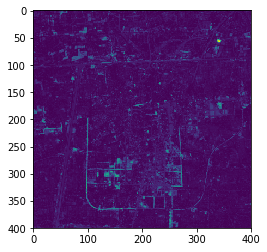

In [12]:
plt.imshow(ddd)